In [1]:
import json
import torch
from Transformer_SSL.models.swin_transformer import DoubleSwinTransformerDownstream
from utils import save_checkpoint_single_model, dotdictify
from Transformer_SSL.models import build_model
from dfc_dataset import DFCDataset


DFC_map_clean = {
    0: "Forest",
    1: "Shrubland",
    2: "Grassland",
    3: "Wetlands",
    4: "Croplands",
    5: "Urban/Built-up",
    6: "Barren",
    7: "Water",
    255: "Invalid",
}

data_config = {
    'train_dir': 'data/data_disini', # path to the training directory,  
    'val_dir': 'data/data_disini', # path to the validation directory,
    'train_mode': 'validation', # can be one of the following: 'test', 'validation'
    'val_mode': 'test', # can be one of the following: 'test', 'validation'
    'num_classes': 8, # number of classes in the dataset.
    'clip_sample_values': True, # clip (limit) values
    'train_used_data_fraction': 1, # fraction of data to use, should be in the range [0, 1]
    'val_used_data_fraction': 1,
    'image_px_size': 224, # image size (224x224)
    'cover_all_parts_train': True, # if True, if image_px_size is not 224 during training, we use a random crop of the image
    'cover_all_parts_validation': True, # if True, if image_px_size is not 224 during validation, we use a non-overlapping sliding window to cover the entire image
    'seed': 42,
}

train_config = {
    's1_input_channels': 2,
    's2_input_channels': 13,
    'finetuning': True, # If false, backbone layers is frozen and only the head is trained
    'classifier_lr': 3e-6,
    'learning_rate': 0.00001,
    'adam_betas': (0.9, 0.999), 
    'weight_decay': 0.001,
    'dataloader_workers': 4,
    'batch_size': 16,
    'epochs': 5, 
    'target': 'dfc_label'
}

val_dataset = DFCDataset(
    data_config['val_dir'],
    mode=data_config['val_mode'],
    clip_sample_values=data_config['clip_sample_values'],
    used_data_fraction=data_config['val_used_data_fraction'],
    image_px_size=data_config['image_px_size'],
    cover_all_parts=data_config['cover_all_parts_validation'],
    seed=data_config['seed'],
)

class DoubleSwinTransformerClassifier(torch.nn.Module):
    def __init__(self, encoder1, encoder2, out_dim, device, freeze_layers=True):
        super(DoubleSwinTransformerClassifier, self).__init__()
        
        # If you're only using one of the two backbones, just comment the one you don't need
        self.backbone1 = encoder1
        self.backbone2 = encoder2

        self.device = device

        # add final linear layer
        self.fc = torch.nn.Linear(
            self.backbone2.num_features + self.backbone1.num_features,
            out_dim,
            bias=True,
        )

        # freeze all layers but the last fc
        if freeze_layers:
            for name, param in self.named_parameters():
                if name not in ["fc.weight", "fc.bias"]:
                    param.requires_grad = False

    def forward(self, x):
        x1, _, _ = self.backbone1.forward_features(x["s1"].to(self.device))
        x2, _, _ = self.backbone2.forward_features(x["s2"].to(self.device))

        z = torch.cat([x1, x2], dim=1)
        z = self.fc(z)
        
        # If you're only using one of the two backbones, you may comment the lines above and use the following:
        # x1, _, _ = self.backbone1.forward_features(x["s1"].to(self.device))
        # z = self.fc(x1)

        return z


accelerator = 'cpu'
checkpoint = torch.load("checkpoints/swin_t.pth", map_location=torch.device(accelerator))
weights = checkpoint["state_dict"]

s1_weights = {k[len("backbone1."):]: v for k, v in weights.items() if "backbone1" in k}
s2_weights = {k[len("backbone2."):]: v for k, v in weights.items() if "backbone2" in k}

input_channels = train_config['s1_input_channels'] + train_config['s2_input_channels']

with open("configs/backbone_config.json", "r") as fp:
    swin_conf = dotdictify(json.load(fp))

s1_backbone = build_model(swin_conf.model_config)
swin_conf.model_config.MODEL.SWIN.IN_CHANS = 13
s2_backbone = build_model(swin_conf.model_config)
s1_backbone.load_state_dict(s1_weights)
s2_backbone.load_state_dict(s2_weights)


device = torch.device(accelerator)
model = DoubleSwinTransformerClassifier(s1_backbone, s2_backbone, out_dim=data_config['num_classes'], device=device)
model = model.to(device)
model.load_state_dict(torch.load("checkpoints/classifier-epoch-4.pth"))

/Users/aradinka/miniforge3/envs/ssl/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/Users/aradinka/miniforge3/envs/ssl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/aradinka/miniforge3/envs/ssl/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

data/data_disini/ROIs0000_test/s1_0/ROIs0000_test_s1_0_p4548.tif
data/data_disini/ROIs0000_test/s2_0/ROIs0000_test_s2_0_p4548.tif
data/data_disini/ROIs0000_test/lc_0/ROIs0000_test_lc_0_p4548.tif
data/data_disini/ROIs0000_test/dfc_0/ROIs0000_test_dfc_0_p4548.tif
data/data_disini/ROIs0000_test/s1_0/ROIs0000_test_s1_0_p4548.tif
data/data_disini/ROIs0000_test/s2_0/ROIs0000_test_s2_0_p4548.tif
data/data_disini/ROIs0000_test/lc_0/ROIs0000_test_lc_0_p4548.tif
data/data_disini/ROIs0000_test/dfc_0/ROIs0000_test_dfc_0_p4548.tif
Predicted class: Forest
data/data_disini/ROIs0000_test/s1_0/ROIs0000_test_s1_0_p4548.tif
data/data_disini/ROIs0000_test/s2_0/ROIs0000_test_s2_0_p4548.tif
data/data_disini/ROIs0000_test/lc_0/ROIs0000_test_lc_0_p4548.tif
data/data_disini/ROIs0000_test/dfc_0/ROIs0000_test_dfc_0_p4548.tif
Ground-truth class:  Forest
data/data_disini/ROIs0000_test/s1_0/ROIs0000_test_s1_0_p4548.tif
data/data_disini/ROIs0000_test/s2_0/ROIs0000_test_s2_0_p4548.tif
data/data_disini/ROIs0000_test/l

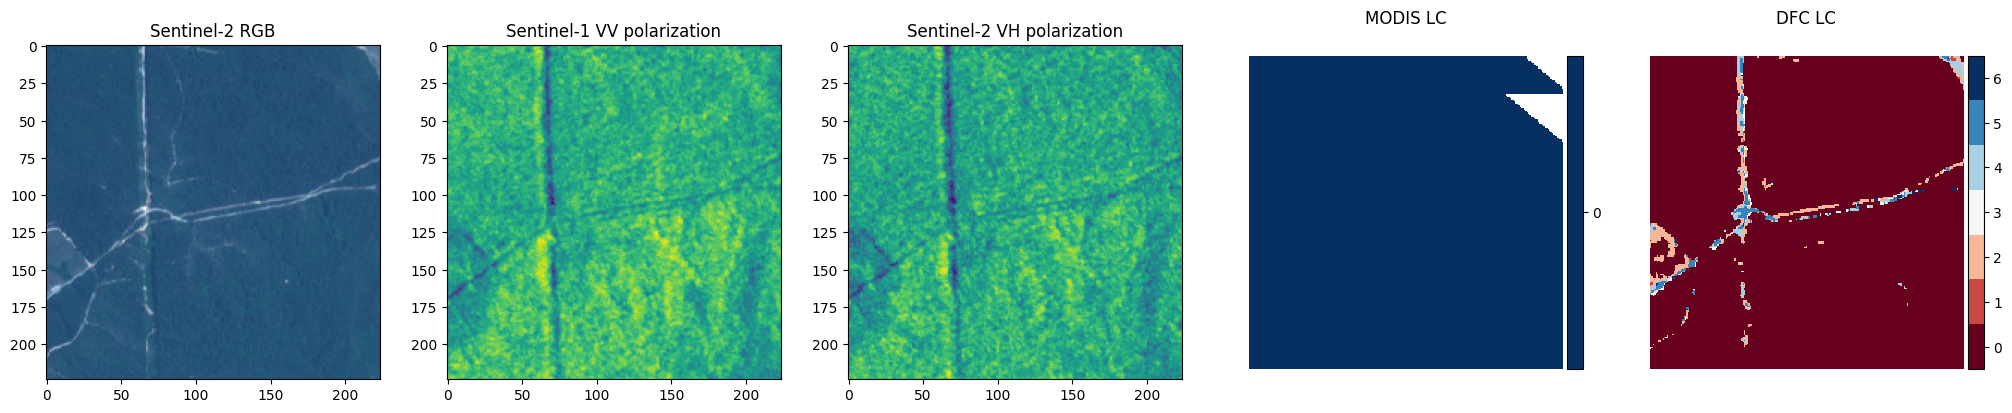

In [2]:
image_index = 13
img = {"s1": torch.unsqueeze(val_dataset[image_index]['s1'], 0), "s2": torch.unsqueeze(val_dataset[image_index]['s2'], 0)} # adding an extra dimension for batch information
model.eval()
output = model(img)

print(f'Predicted class: {DFC_map_clean[torch.argmax(output).item()]}')
print('Ground-truth class: ', DFC_map_clean[val_dataset[image_index][train_config['target']]])

val_dataset.visualize_observation(image_index)

In [9]:
val_dataset[1]

{'s1': tensor([[[0.5268, 0.5221, 0.5245,  ..., 0.6396, 0.6516, 0.6601],
          [0.5378, 0.5294, 0.5594,  ..., 0.6499, 0.6469, 0.6350],
          [0.5418, 0.5470, 0.5482,  ..., 0.6473, 0.6334, 0.6376],
          ...,
          [0.5752, 0.5868, 0.5776,  ..., 0.6329, 0.6387, 0.6519],
          [0.5794, 0.5957, 0.5905,  ..., 0.6511, 0.6447, 0.6710],
          [0.5874, 0.6083, 0.5836,  ..., 0.6532, 0.6562, 0.6631]],
 
         [[0.1644, 0.1774, 0.1858,  ..., 0.4467, 0.4440, 0.4548],
          [0.1941, 0.2008, 0.2007,  ..., 0.4509, 0.4609, 0.4402],
          [0.2188, 0.2199, 0.2239,  ..., 0.4487, 0.4397, 0.4242],
          ...,
          [0.2909, 0.2626, 0.2266,  ..., 0.4379, 0.4398, 0.4431],
          [0.2815, 0.2712, 0.2572,  ..., 0.4404, 0.4514, 0.4535],
          [0.2755, 0.2817, 0.2550,  ..., 0.4526, 0.4522, 0.4597]]]),
 's2': tensor([[[0.6428, 0.6428, 0.6428,  ..., 0.4105, 0.4105, 0.4105],
          [0.6279, 0.6279, 0.6279,  ..., 0.4105, 0.4105, 0.4105],
          [0.6279, 0.6279, 0

In [6]:
val_dataset[0]['s1']

tensor([[[0.7813, 0.7561, 0.6941,  ..., 0.8355, 0.7433, 0.6932],
         [0.6911, 0.6553, 0.7027,  ..., 0.7621, 0.7059, 0.6225],
         [0.6789, 0.6789, 0.7660,  ..., 0.7999, 0.7302, 0.6975],
         ...,
         [0.7857, 0.7708, 0.8086,  ..., 0.7536, 0.7983, 0.7983],
         [0.8057, 0.7727, 0.7831,  ..., 0.7087, 0.7027, 0.8186],
         [0.7342, 0.8205, 0.8385,  ..., 0.8615, 0.8212, 0.7589]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])

In [7]:
DFC_map_clean = {
    0: "Forest",
    1: "Shrubland",
    2: "Grassland",
    3: "Wetlands",
    4: "Croplands",
    5: "Urban/Built-up",
    6: "Barren",
    7: "Water",
    255: "Invalid",
}

# Manual

In [49]:
# S1
import rasterio
from rasterio.windows import Window
from enum import Enum
import numpy as np

patch_path = "data/data_disini/ROIs0000_test/s1_0/ROIs0000_test_s1_0_p1101.tif"
image_px_size = 224



In [50]:
class S1Bands(Enum):
    VV = 1
    VH = 2
    ALL = [VV, VH]
    NONE = None

class Sensor(Enum):
    s1 = "s1"
    s2 = "s2"
    lc = "lc"
    dfc = "dfc"

class S2Bands(Enum):
    B01 = aerosol = 1
    B02 = blue = 2
    B03 = green = 3
    B04 = red = 4
    B05 = re1 = 5
    B06 = re2 = 6
    B07 = re3 = 7
    B08 = nir1 = 8
    B08A = nir2 = 9
    B09 = vapor = 10
    B10 = cirrus = 11
    B11 = swir1 = 12
    B12 = swir2 = 13
    ALL = [B01, B02, B03, B04, B05, B06, B07, B08, B08A, B09, B10, B11, B12]
    RGB = [B04, B03, B02]
    NONE = None

class LCBands(Enum):
    LC = lc = 0
    DFC = dfc = 1
    ALL = [DFC]
    NONE = None

In [51]:
bands = S1Bands.ALL
if isinstance(bands, (list, tuple)):
    b = bands[0]
else:
    b = bands

In [52]:
if isinstance(b, S1Bands):
    # print("Yes")
    sensor = Sensor.s1.value
    bandEnum = S1Bands
elif isinstance(b, S2Bands):
    sensor = Sensor.s2.value
    bandEnum = S2Bands
elif isinstance(b, LCBands):
    if LCBands(bands) == LCBands.LC:
        sensor = Sensor.lc.value 
    else:
        sensor = Sensor.dfc.value 

    bands = LCBands(1)
    bandEnum = LCBands
else:
    raise Exception("Invalid bands specified")
bands 

<S1Bands.ALL: [1, 2]>

In [53]:
bandEnum

<enum 'S1Bands'>

In [54]:
if isinstance(bands, (list, tuple)):
    bands = [b.value for b in bands]
else:
    bands = bandEnum(bands).value
bands

[1, 2]

In [55]:
if image_px_size != 256:
    # crop the data to image_px_size times image_px_size (e.g. 128x128)
    x_offset, y_offset = np.random.randint(0, 256 - image_px_size, 2)
    window = Window(x_offset, y_offset, image_px_size, image_px_size)
else:
    window = None

with rasterio.open(patch_path) as patch:
    if window is not None:
        s1 = patch.read(bands, window=window) 
    else:
        s1 = patch.read(bands)
    bounds = patch.bounds

In [56]:
s1

array([[[-14.20106501, -14.69433641, -14.82744924, ..., -11.99402508,
         -12.63864703, -12.26624703],
        [-13.2802286 , -13.40922659, -13.72393717, ..., -12.10325143,
         -12.41867646, -11.59958615],
        [-14.40311689, -12.96804504, -12.99661228, ..., -12.81945184,
         -14.06819845, -13.23096838],
        ...,
        [-14.41432749, -15.20306822, -15.32313661, ..., -16.57199602,
         -15.51971027, -14.95692719],
        [-13.53502232, -14.37902306, -14.64131238, ..., -16.75381764,
         -16.00914425, -14.90948934],
        [-13.4641911 , -14.25310459, -14.57492952, ..., -15.96325761,
         -15.29758798, -15.23008824]],

       [[-19.44494868, -20.95576034, -20.95472618, ..., -18.29853491,
         -19.30996063, -18.78496575],
        [-20.65597629, -20.55038391, -19.80454104, ..., -17.99495225,
         -18.10354254, -18.92214119],
        [-20.78535638, -21.46372101, -20.40088921, ..., -17.86679372,
         -17.15926272, -17.82485663],
        ...,


In [57]:
clip_sample_values = True
if clip_sample_values:
    s1 = np.clip(s1, a_min=-25, a_max=0)
    s1 = (
        s1 + 25
    )  # go from [-25,0] to [0,25] interval to make normalization easier
    s2 = np.clip(s2, a_min=0, a_max=1e4)

## Function


In [116]:
def get_patch(patch_path, bands, window=None):
    """
        Returns raster data and image bounds for the defined bands of a specific patch
        This method only loads a sinlge patch from a single sensor as defined by the bands specified
    """
    # season = Seasons(season).value
    sensor = None

    if not bands:
        return None, None

    if isinstance(bands, (list, tuple)):
        b = bands[0]
    else:
        b = bands
    
    if isinstance(b, S1Bands):
        sensor = Sensor.s1.value
        bandEnum = S1Bands
    elif isinstance(b, S2Bands):
        sensor = Sensor.s2.value
        bandEnum = S2Bands
    elif isinstance(b, LCBands):
        if LCBands(bands) == LCBands.LC:
            sensor = Sensor.lc.value 
        else:
            sensor = Sensor.dfc.value 

        bands = LCBands(1)
        bandEnum = LCBands
    else:
        raise Exception("Invalid bands specified")

    if isinstance(bands, (list, tuple)):
        bands = [b.value for b in bands]
    else:
        bands = bandEnum(bands).value

    with rasterio.open(patch_path) as patch:
        if window is not None:
            data = patch.read(bands, window=window) 
        else:
            data = patch.read(bands)
        bounds = patch.bounds

    # Remap IGBP to DFC bands
    # if sensor  == "lc":
    #     data = IGBP2DFC[data]

    if len(data.shape) == 2:
        data = np.expand_dims(data, axis=0)

    return data, bounds

image_px_size = 224
if image_px_size != 256:
    # crop the data to image_px_size times image_px_size (e.g. 128x128)
    x_offset, y_offset = np.random.randint(0, 256 - image_px_size, 2)
    window = Window(x_offset, y_offset, image_px_size, image_px_size)
else:
    window = None

s1, bounds1 = get_patch(patch_path="data/data_disini/ROIs0000_test/s1_0/ROIs0000_test_s1_0_p1101.tif", bands=S1Bands.ALL, window=window)
s2, bounds2 = get_patch(patch_path="data/data_disini/ROIs0000_test/s2_0/ROIs0000_test_s2_0_p1101.tif", bands=S2Bands.ALL, window=window)

clip_sample_values = True
if clip_sample_values:
    s1 = np.clip(s1, a_min=-25, a_max=0)
    s1 = (
        s1 + 25
    )  # go from [-25,0] to [0,25] interval to make normalization easier
    s2 = np.clip(s2, a_min=0, a_max=1e4)

import albumentations as A
from utils import AlbumentationsToTorchTransform
from albumentations.pytorch import ToTensorV2

base_aug = A.Compose([ToTensorV2()])
base_transform = AlbumentationsToTorchTransform(base_aug)

s1 = base_transform(np.moveaxis(s1, 0, -1))
s2 = base_transform(np.moveaxis(s2, 0, -1))


import torch
# normalize images channel wise
s1_maxs = []
for ch_idx in range(s1.shape[0]):
    s1_maxs.append(
        torch.ones((s1.shape[-2], s1.shape[-1])) * s1[ch_idx].max().item()
        + 1e-5
    )
s1_maxs = torch.stack(s1_maxs)
s2_maxs = []
for b_idx in range(s2.shape[0]):
    s2_maxs.append(
        torch.ones((s2.shape[-2], s2.shape[-1])) * s2[b_idx].max().item() + 1e-5
    )
s2_maxs = torch.stack(s2_maxs)
normalize = True
if normalize:
    s1 = s1 / s1_maxs
    s2 = s2 / s2_maxs

In [120]:
s1.shape

torch.Size([2, 224, 224])

In [119]:
s2.shape

torch.Size([13, 224, 224])

In [65]:
import json
import torch
from Transformer_SSL.models.swin_transformer import DoubleSwinTransformerDownstream
from utils import save_checkpoint_single_model, dotdictify
from Transformer_SSL.models import build_model
from dfc_dataset import DFCDataset

DFC_map_clean = {
    0: "Forest",
    1: "Shrubland",
    2: "Grassland",
    3: "Wetlands",
    4: "Croplands",
    5: "Urban/Built-up",
    6: "Barren",
    7: "Water",
    255: "Invalid",
}

data_config = {
    'train_dir': 'data/data_disini', # path to the training directory,  
    'val_dir': 'data/data_disini', # path to the validation directory,
    'train_mode': 'validation', # can be one of the following: 'test', 'validation'
    'val_mode': 'test', # can be one of the following: 'test', 'validation'
    'num_classes': 8, # number of classes in the dataset.
    'clip_sample_values': True, # clip (limit) values
    'train_used_data_fraction': 1, # fraction of data to use, should be in the range [0, 1]
    'val_used_data_fraction': 1,
    'image_px_size': 224, # image size (224x224)
    'cover_all_parts_train': True, # if True, if image_px_size is not 224 during training, we use a random crop of the image
    'cover_all_parts_validation': True, # if True, if image_px_size is not 224 during validation, we use a non-overlapping sliding window to cover the entire image
    'seed': 42,
}

train_config = {
    's1_input_channels': 2,
    's2_input_channels': 13,
    'finetuning': True, # If false, backbone layers is frozen and only the head is trained
    'classifier_lr': 3e-6,
    'learning_rate': 0.00001,
    'adam_betas': (0.9, 0.999), 
    'weight_decay': 0.001,
    'dataloader_workers': 4,
    'batch_size': 16,
    'epochs': 5, 
    'target': 'dfc_label'
}

class DoubleSwinTransformerClassifier(torch.nn.Module):
    def __init__(self, encoder1, encoder2, out_dim, device, freeze_layers=True):
        super(DoubleSwinTransformerClassifier, self).__init__()
        
        # If you're only using one of the two backbones, just comment the one you don't need
        self.backbone1 = encoder1
        self.backbone2 = encoder2

        self.device = device

        # add final linear layer
        self.fc = torch.nn.Linear(
            self.backbone2.num_features + self.backbone1.num_features,
            out_dim,
            bias=True,
        )

        # freeze all layers but the last fc
        if freeze_layers:
            for name, param in self.named_parameters():
                if name not in ["fc.weight", "fc.bias"]:
                    param.requires_grad = False

    def forward(self, x):
        x1, _, _ = self.backbone1.forward_features(x["s1"].to(self.device))
        x2, _, _ = self.backbone2.forward_features(x["s2"].to(self.device))

        z = torch.cat([x1, x2], dim=1)
        z = self.fc(z)
        
        # If you're only using one of the two backbones, you may comment the lines above and use the following:
        # x1, _, _ = self.backbone1.forward_features(x["s1"].to(self.device))
        # z = self.fc(x1)

        return z


accelerator = 'cpu'
checkpoint = torch.load("checkpoints/swin_t.pth", map_location=torch.device(accelerator))
weights = checkpoint["state_dict"]

s1_weights = {k[len("backbone1."):]: v for k, v in weights.items() if "backbone1" in k}
s2_weights = {k[len("backbone2."):]: v for k, v in weights.items() if "backbone2" in k}

input_channels = train_config['s1_input_channels'] + train_config['s2_input_channels']

with open("configs/backbone_config.json", "r") as fp:
    swin_conf = dotdictify(json.load(fp))

s1_backbone = build_model(swin_conf.model_config)
swin_conf.model_config.MODEL.SWIN.IN_CHANS = 13
s2_backbone = build_model(swin_conf.model_config)
s1_backbone.load_state_dict(s1_weights)
s2_backbone.load_state_dict(s2_weights)


device = torch.device(accelerator)
model = DoubleSwinTransformerClassifier(s1_backbone, s2_backbone, out_dim=data_config['num_classes'], device=device)
model = model.to(device)
model.load_state_dict(torch.load("checkpoints/classifier-epoch-4.pth"))

# img = {"s1": torch.unsqueeze(val_dataset[0]['s1'], 0), "s2": torch.unsqueeze(val_dataset[0]['s2'], 0)} # adding an extra dimension for batch information
img = {"s1": torch.unsqueeze(s1, 0), "s2": torch.unsqueeze(s2, 0)} # adding an extra dimension for batch information
model.eval()
output = model(img)

<All keys matched successfully>

In [121]:
s1

tensor([[[0.4413, 0.4337, 0.4641,  ..., 0.5336, 0.5121, 0.4972],
         [0.4946, 0.4794, 0.4793,  ..., 0.5322, 0.5004, 0.5109],
         [0.5040, 0.5040, 0.4459,  ..., 0.5376, 0.5122, 0.5183],
         ...,
         [0.4055, 0.4494, 0.4936,  ..., 0.5344, 0.5340, 0.4637],
         [0.4871, 0.5162, 0.5484,  ..., 0.5382, 0.5163, 0.5059],
         [0.5174, 0.5318, 0.5877,  ..., 0.5096, 0.4880, 0.5028]],

        [[0.3358, 0.4226, 0.3082,  ..., 0.3977, 0.4498, 0.4299],
         [0.3212, 0.3766, 0.3187,  ..., 0.4373, 0.4396, 0.3950],
         [0.3694, 0.2911, 0.2667,  ..., 0.4767, 0.4563, 0.4330],
         ...,
         [0.2839, 0.3520, 0.3520,  ..., 0.3652, 0.2426, 0.3273],
         [0.2918, 0.4003, 0.4414,  ..., 0.2907, 0.3250, 0.3177],
         [0.3565, 0.3438, 0.5078,  ..., 0.3978, 0.3978, 0.3569]]],
       dtype=torch.float64)

In [ ]:
print(f'Predicted class: {DFC_map_clean[torch.argmax(output).item()]}')
print('Ground-truth class: ', DFC_map_clean[val_dataset[image_index][train_config['target']]])

val_dataset.visualize_observation(image_index)